# Geophysical particle filter

The point of this notebook is to recreate on an unclassified dataset and unrelated codebase the deep water bathymetric particle filter results, and include additional results for gravity and magnetic measurements.

In [1]:
import numpy as np
from gmt_tool import get_map_section, inflate_bounds
from haversine import haversine, Unit
from tools import load_trackline_data
from matplotlib import pyplot as plt
from particle_filter import run_particle_filter

In [2]:
num = 3
data = load_trackline_data(f'./data/processed/marine_trackline_{num}.csv')
data.head()

c:\Users\james\geophysical_nav\research\tools.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["dt"].iloc[0] = timedelta(seconds=0)


,LAT,LON,BAT_TTIME,CORR_DEPTH,MAG_TOT,MAG_RES,FREEAIR,TIME,dt,distance,heading,vel,vel_filt,vN,vE
2000-07-21 12:35:00-12:00,47.35305,-45.21810,0.288,211.0,50386.0,-92.0,69.9,0 days 00:00:00,0 days 00:00:00,0.000000,0.000000,NaN,NaN,NaN,NaN
2000-07-21 12:36:00-12:00,47.35221,-45.21668,0.286,209.0,50395.0,-82.0,69.8,0 days 00:01:00,0 days 00:01:00,142.012154,131.125500,2.366869,2.366869,-1.556715,1.782893
2000-07-21 12:37:00-12:00,47.35140,-45.21524,0.286,209.0,50408.0,-69.0,69.6,0 days 00:02:00,0 days 00:01:00,140.997863,129.701117,2.349964,2.358417,-1.506516,1.814535
2000-07-21 12:38:00-12:00,47.35056,-45.21382,0.286,209.0,50418.0,-58.0,69.4,0 days 00:03:00,0 days 00:01:00,142.014673,131.124612,2.366911,2.366869,-1.556687,1.782917
2000-07-21 12:39:00-12:00,47.34974,-45.21237,0.297,218.0,50436.0,-39.0,69.0,0 days 00:04:00,0 days 00:01:00,142.290895,129.850945,2.371515,2.366890,-1.516686,1.817095


In [3]:
min_lon = data.LON.min()
max_lon = data.LON.max()
min_lat = data.LAT.min()
max_lat = data.LAT.max()
min_lon, min_lat, max_lon, max_lat = inflate_bounds(min_lon, min_lat, max_lon, max_lat, 0.5)
geo_map = get_map_section(min_lon, max_lon, min_lat, max_lat, 'relief', '15s', f'track{num}')

gmt grdcut @earth_relief_15s_p -Rd-46.52569/-41.29532999999998/45.085229999999996/48.108990000000006 -Gtrack3.nc
CompletedProcess(args='conda run -n PyGMT gmt grdcut @earth_relief_15s_p -Rd-46.52569/-41.29532999999998/45.085229999999996/48.108990000000006 -Gtrack3.nc', returncode=0, stdout='', stderr='grdcut [WARNING]: (w - x_min) must equal (NX + eps) * x_inc), where NX is an integer and |eps| <= 0.0001.\ngrdcut [WARNING]: w reset from -46.52569 to -46.5291666667\ngrdcut [WARNING]: (e - x_min) must equal (NX + eps) * x_inc), where NX is an integer and |eps| <= 0.0001.\ngrdcut [WARNING]: e reset from -41.29533 to -41.2916666667\ngrdcut [WARNING]: (s - y_min) must equal (NY + eps) * y_inc), where NY is an integer and |eps| <= 0.0001.\ngrdcut [WARNING]: s reset from 45.08523 to 45.0833333333\ngrdcut [WARNING]: (n - y_min) must equal (NY + eps) * y_inc), where NY is an integer and |eps| <= 0.0001.\ngrdcut [WARNING]: n reset from 48.10899 to 48.1125\n\n')


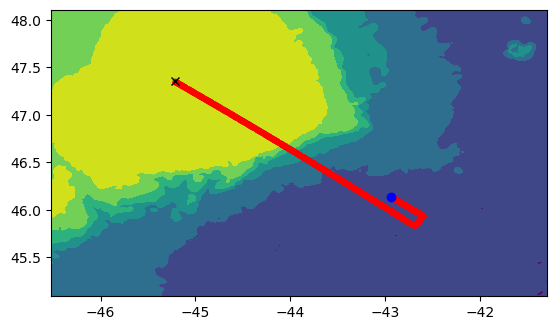

In [4]:
plt.contourf(geo_map.lon, geo_map.lat, geo_map.data)
plt.plot(data.LON, data.LAT, '.r')
plt.plot(data.LON[0], data.LAT[0], 'xk')
plt.plot(data.LON[-1], data.LAT[-1], 'bo')
plt.axis('image')
plt.show()

In [5]:
N = 1000
# Intial parameters
mu = [data.LAT[0], data.LON[0], 0, 0, 0, 0]
cov = np.diag([1/60, 1/60, 0, 0.1, 0.1, 0])
particles = np.random.multivariate_normal(mu, cov, (N,))
weights = np.ones((N,)) / N
rms_error = np.zeros((len(data,)))
error = np.zeros((len(data,)))


estimate, error, rms_error = run_particle_filter(mu, cov, N, data, geo_map)


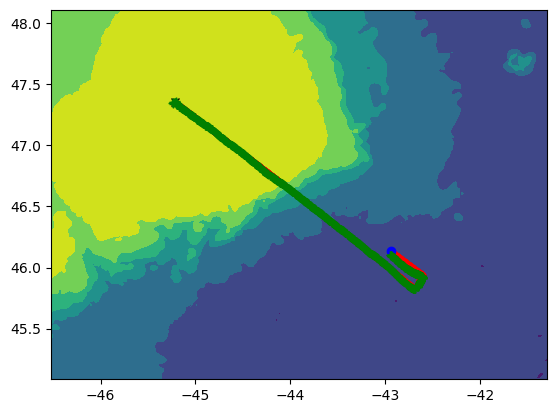

In [6]:
plt.contourf(geo_map.lon, geo_map.lat, geo_map.data)
plt.plot(data.LON, data.LAT, '.r')
plt.plot(data.LON[0], data.LAT[0], 'xk')
plt.plot(data.LON[-1], data.LAT[-1], 'bo')
plt.plot(estimate[:, 1], estimate[:, 0], 'g+')
plt.show()

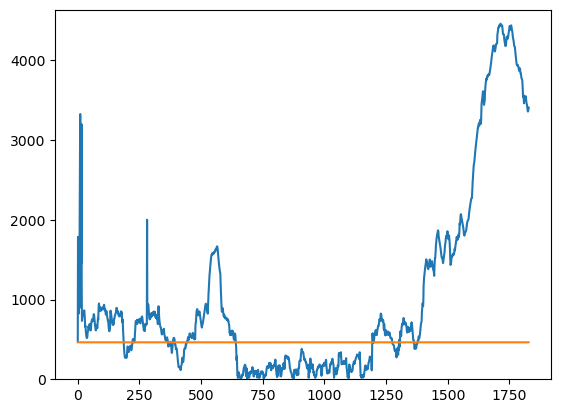

In [7]:
res = haversine((0,0), (geo_map.lat[1] - geo_map.lat[0], 0), Unit.METERS)

plt.plot(error)
plt.plot(np.ones_like(error)*res)
plt.ylim([0, 10*res])
plt.show()